In [387]:
import pyro
import pyro.optim
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO, RenyiELBO, TraceGraph_ELBO
import torch
import torch.distributions.constraints as constraints
from pyro.infer import Predictive, TracePosterior
from pyro.infer import MCMC, NUTS

In [388]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as onp
from sklearn import datasets
from sklearn.model_selection import train_test_split
import pandas as pd
import pymc3 as pm
import seaborn as sns
import theano

In [389]:
# Load the diabetes dataset
diabetes = datasets.load_diabetes()
X = pd.DataFrame(diabetes['data'], columns = diabetes['feature_names'])
y = pd.DataFrame(diabetes['target'], columns = ['y'])
data = X
data = data * onp.shape(data)[0]
data['y'] = onp.log(y)
data['sex'][data['sex']>0] = 1
data['sex'][data['sex']<0] = 0
train_data, test_data = train_test_split(data, test_size=0.2)

In [377]:
# Model Spec 1
def model(age, sex, bmi, bp, y):
    a = pyro.sample("a", dist.Normal(0., 10.))
    b_age = pyro.sample("b_age", dist.Normal(0., 1.))
    b_sex = pyro.sample("b_sex", dist.Normal(0., 1.))
    b_bmi = pyro.sample("b_bmi", dist.Normal(0., 1.))
    b_bp = pyro.sample("b_bp", dist.Normal(0., 1.))
    sigma = pyro.sample("sigma", dist.Gamma(1., 1.))
    mean = a + b_age * age + b_sex * sex + b_bmi * bmi + b_bp * bp
    with pyro.plate("data", len(age)):
        pyro.sample("obs", dist.Normal(mean, sigma), obs=y)

In [390]:
# Model Spec 2
def model(age, sex, bmi, bp, y):
    a = pyro.sample("a", dist.Normal(0., 10.))
    b_age = pyro.sample("b_age", dist.Normal(0., 1.))
    b_sex = pyro.sample("b_sex", dist.Normal(0., 1.))
    b_bmi = pyro.sample("b_bmi", dist.Normal(0., 1.))
    b_bp = pyro.sample("b_bp", dist.Normal(0., 1.))
    sigma = pyro.sample("sigma", dist.HalfCauchy(10.))
    mean = a + b_age * age + b_sex * sex + b_bmi * bmi + b_bp * bp
    with pyro.plate("data", len(age)):
        pyro.sample("obs", dist.Normal(mean, sigma), obs=y)

In [378]:
# Guide Spec 1
def guide(age, sex, bmi, bp, y):
    a_loc = pyro.param('a_loc', torch.tensor(0.))
    a_scale = pyro.param('a_scale', torch.tensor(1.),
                         constraint=constraints.positive)
    sigma_loc = pyro.param('sigma_loc', torch.tensor(1.),
                             constraint=constraints.positive)
    weights_loc = pyro.param('weights_loc', torch.zeros(4))
    weights_scale = pyro.param('weights_scale', torch.ones(4),
                               constraint=constraints.positive)
    a = pyro.sample("a", dist.Normal(a_loc, a_scale))
    b_age = pyro.sample("b_age", dist.Normal(weights_loc[0], weights_scale[0]))
    b_sex = pyro.sample("b_sex", dist.Normal(weights_loc[1], weights_scale[1]))
    b_bmi = pyro.sample("b_bmi", dist.Normal(weights_loc[2], weights_scale[2]))
    b_bp = pyro.sample("b_bp", dist.Normal(weights_loc[3], weights_scale[3]))
    sigma = pyro.sample("sigma", dist.Normal(sigma_loc, torch.tensor(0.05)))
    mean = a + b_age * age + b_sex * sex + b_bmi * bmi + b_bp * bp

In [391]:
# Guide Spec 2
def guide(age, sex, bmi, bp, y):
    a_df = pyro.param('a_loc', torch.tensor(40.))
    sigma_df = pyro.param('sigma_loc', torch.tensor(3.),
                             constraint=constraints.positive)
    weights_df = pyro.param('weights_loc', torch.tensor(onp.array([40.,40.,40.,40.])))

    a = pyro.sample("a", dist.StudentT(a_df))
    b_age = pyro.sample("b_age", dist.StudentT(weights_df[0]))
    b_sex = pyro.sample("b_sex", dist.StudentT(weights_df[1]))
    b_bmi = pyro.sample("b_bmi", dist.StudentT(weights_df[2]))
    b_bp = pyro.sample("b_bp", dist.StudentT(weights_df[3]))
    sigma = pyro.sample("sigma", dist.Chi2(sigma_df))
    mean = a + b_age * age + b_sex * sex + b_bmi * bmi + b_bp * bp

In [392]:
# Utility function to print latent sites' quantile information.
def summary(samples):
    site_stats = {}
    for site_name, values in samples.items():
        marginal_site = pd.DataFrame(values)
        describe = marginal_site.describe(percentiles=[.05, 0.25, 0.5, 0.75, 0.95]).transpose()
        site_stats[site_name] = describe[["mean", "std", "5%", "25%", "50%", "75%", "95%"]]
    return site_stats

In [393]:
# Prepare training data
train_data = train_data[["age","sex","bmi","bp","y"]]
test_data = test_data[["age","sex","bmi","bp","y"]]
train = torch.tensor(train_data.values, dtype=torch.float)

In [395]:
svi = SVI(model,
          guide,
          optim.Adam({"lr": .001}),
          loss=RenyiELBO(alpha=2))
          #loss = TraceGraph_ELBO())
          #loss=Trace_ELBO())

age, sex, bmi, bp, y = train[:, 0], train[:, 1], train[:, 2], train[:, 3], train[:, 4]
pyro.clear_param_store()
num_iters = 50000
for i in range(num_iters):
    elbo = svi.step(age, sex, bmi, bp, y)
    if i % 5000 == 0:
        print("Elbo loss: {}".format(elbo))

Elbo loss: 501182.0458459429
Elbo loss: 175230.96085472748
Elbo loss: 22094.793319457047
Elbo loss: 28127.704698530797
Elbo loss: 11266.84227435686
Elbo loss: 5071.018268438067
Elbo loss: 10748.43643862144
Elbo loss: 2067.279629070753
Elbo loss: 1858.6473646190555
Elbo loss: 1950.9343498374044


In [396]:
num_samples = 10000
predictive = Predictive(model, guide=guide, num_samples=num_samples)
svi_samples_renyi2 = {k: v.reshape(num_samples).detach().cpu().numpy()
                     for k, v in predictive(y, age, sex, bmi, bp).items()
                     if k != "obs"}

In [397]:
for site, values in summary(svi_samples_renyi2).items():
    print("Site: {}".format(site))
    print(values, "\n")

Site: a
       mean       std        5%       25%      50%       75%       95%
0 -0.006746  1.038023 -1.693214 -0.704815 -0.00738  0.679106  1.711821 

Site: b_age
       mean       std        5%       25%       50%       75%       95%
0 -0.000251  1.015135 -1.671927 -0.673685 -0.003558  0.674557  1.691623 

Site: b_sex
       mean       std        5%       25%       50%       75%       95%
0  0.000366  1.004327 -1.689571 -0.660791  0.008995  0.667139  1.656127 

Site: b_bmi
       mean       std        5%       25%       50%       75%       95%
0  0.002779  1.024421 -1.656634 -0.674977  0.002411  0.671102  1.696936 

Site: b_bp
       mean       std        5%       25%       50%       75%       95%
0  0.004303  1.037712 -1.693482 -0.686378 -0.003389  0.677691  1.720674 

Site: sigma
        mean      std         5%        25%        50%        75%        95%
0  49.546112  9.77288  34.653699  42.592435  48.873631  55.768131  66.731056 



In [383]:
for site, values in summary(svi_samples_renyi).items():
    print("Site: {}".format(site))
    print(values, "\n")

Site: a
       mean       std        5%       25%       50%      75%       95%
0  4.921474  0.023255  4.883207  4.905735  4.921667  4.93729  4.958932 

Site: b_age
       mean       std       5%      25%       50%       75%       95%
0  0.001261  0.001132 -0.00058  0.00049  0.001256  0.002017  0.003164 

Site: b_sex
       mean       std        5%       25%       50%       75%       95%
0 -0.092666  0.035262 -0.151069 -0.116563 -0.092624 -0.069206 -0.033763 

Site: b_bmi
       mean       std        5%       25%       50%       75%      95%
0  0.010513  0.001119  0.008707  0.009746  0.010504  0.011273  0.01236 

Site: b_bp
       mean       std        5%       25%       50%       75%       95%
0  0.007495  0.001128  0.005619  0.006732  0.007517  0.008258  0.009333 

Site: sigma
       mean       std        5%       25%       50%       75%       95%
0  0.469097  0.049943  0.386626  0.435532  0.469432  0.502386  0.551289 



In [384]:
for site, values in summary(svi_samples_kl).items():
    print("Site: {}".format(site))
    print(values, "\n")

Site: a
       mean       std        5%       25%       50%       75%       95%
0  4.922164  0.024043  4.883022  4.905578  4.922166  4.938185  4.961629 

Site: b_age
       mean       std        5%      25%       50%      75%       95%
0  0.000805  0.001177 -0.001139  0.00001  0.000809  0.00161  0.002724 

Site: b_sex
       mean       std        5%       25%       50%       75%       95%
0 -0.082417  0.034768 -0.139708 -0.105407 -0.082623 -0.058517 -0.026456 

Site: b_bmi
       mean       std        5%       25%       50%       75%       95%
0  0.009894  0.001243  0.007845  0.009065  0.009893  0.010719  0.011958 

Site: b_bp
       mean       std        5%       25%       50%       75%       95%
0  0.006102  0.001208  0.004119  0.005294  0.006104  0.006912  0.008105 

Site: sigma
       mean       std        5%       25%       50%       75%      95%
0  0.472698  0.049487  0.390594  0.439758  0.472459  0.505941  0.55415 



In [365]:
# HMC comparison
nuts_kernel = NUTS(model)

mcmc = MCMC(nuts_kernel, num_samples=5000, warmup_steps=1000)
mcmc.run(age, sex, bmi, bp, y)

hmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}

Sample: 100%|██████████| 6000/6000 [03:41, 27.14it/s, step size=2.21e-01, acc. prob=0.941]


In [398]:
# HMC comparison 2
nuts_kernel = NUTS(model)

mcmc = MCMC(nuts_kernel, num_samples=5000, warmup_steps=1000)
mcmc.run(age, sex, bmi, bp, y)

hmc_samples2 = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}

Sample: 100%|██████████| 6000/6000 [03:29, 28.58it/s, step size=2.44e-01, acc. prob=0.924]


In [399]:
hmc_samples2 = hmc_samples
for site, values in summary(hmc_samples2).items():
    print("Site: {}".format(site))
    print(values, "\n")

Site: a
       mean       std        5%       25%       50%      75%       95%
0  4.924142  0.033294  4.867808  4.901481  4.924569  4.94669  4.978672 

Site: b_age
       mean       std        5%       25%       50%       75%       95%
0  0.001338  0.001207 -0.000612  0.000506  0.001349  0.002157  0.003318 

Site: b_sex
      mean       std        5%       25%       50%       75%       95%
0 -0.07272  0.051394 -0.157408 -0.106563 -0.073359 -0.037995  0.014836 

Site: b_bmi
       mean       std        5%       25%       50%       75%       95%
0  0.012301  0.001205  0.010355  0.011483  0.012285  0.013112  0.014298 

Site: b_bp
       mean       std        5%       25%       50%       75%       95%
0  0.005512  0.001302  0.003412  0.004626  0.005513  0.006366  0.007701 

Site: sigma
       mean      std       5%       25%       50%       75%      95%
0  0.455961  0.01772  0.42761  0.443757  0.455342  0.467665  0.48606 



In [366]:
for site, values in summary(hmc_samples).items():
    print("Site: {}".format(site))
    print(values, "\n")

Site: a
     mean       std        5%       25%       50%       75%       95%
0  4.9268  0.033889  4.872278  4.903988  4.927313  4.949568  4.981813 

Site: b_age
       mean       std        5%       25%      50%       75%       95%
0  0.001082  0.001194 -0.000878  0.000263  0.00108  0.001887  0.003049 

Site: b_sex
       mean       std        5%       25%       50%       75%       95%
0 -0.091342  0.050839 -0.172133 -0.125193 -0.092252 -0.058959 -0.005887 

Site: b_bmi
       mean       std        5%       25%       50%       75%       95%
0  0.011278  0.001237  0.009241  0.010445  0.011271  0.012116  0.013293 

Site: b_bp
       mean       std        5%       25%       50%       75%       95%
0  0.007489  0.001378  0.005219  0.006551  0.007487  0.008419  0.009726 

Site: sigma
       mean       std        5%       25%       50%       75%       95%
0  0.458245  0.017825  0.430162  0.445992  0.457044  0.469585  0.489236 



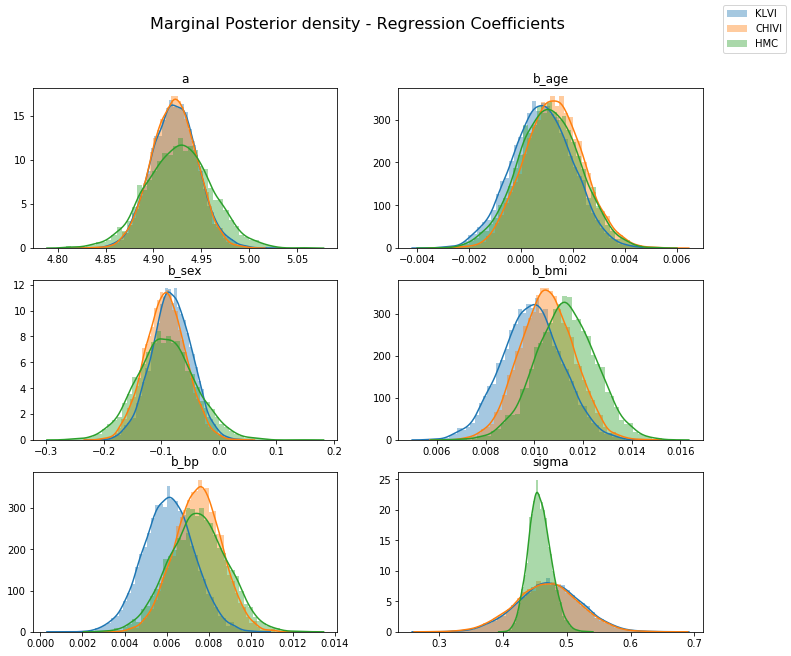

In [386]:
sites = ["a", "b_age", "b_sex", "b_bmi", "b_bp", "sigma"]

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(12, 10))
fig.suptitle("Marginal Posterior density - Regression Coefficients", fontsize=16)
for i, ax in enumerate(axs.reshape(-1)):
    site = sites[i]
    sns.distplot(svi_samples_kl[site], ax=ax, label="KLVI")
    sns.distplot(svi_samples_renyi[site], ax=ax, label="CHIVI")
    sns.distplot(hmc_samples[site], ax=ax, label="HMC")
    ax.set_title(site)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right');
plt.savefig('marginal_posterior_density.pdf')

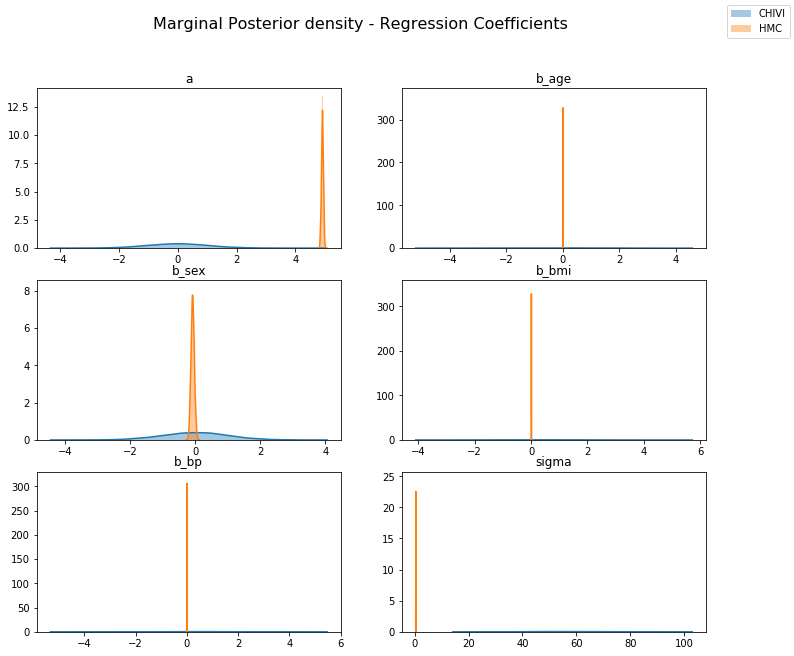

In [400]:
sites = ["a", "b_age", "b_sex", "b_bmi", "b_bp", "sigma"]

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(12, 10))
fig.suptitle("Marginal Posterior density - Regression Coefficients", fontsize=16)
for i, ax in enumerate(axs.reshape(-1)):
    site = sites[i]
    #sns.distplot(svi_samples_kl[site], ax=ax, label="KLVI")
    sns.distplot(svi_samples_renyi2[site], ax=ax, label="CHIVI")
    sns.distplot(hmc_samples2[site], ax=ax, label="HMC")
    ax.set_title(site)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right');
#plt.savefig('marginal_posterior_density.pdf')

In [368]:
from viabel import (all_bounds, error_bounds, wasserstein_bounds, divergence_bound)
from scipy.stats import norm, gamma

In [369]:
num_params = 6
vi_samples = onp.empty(shape=(num_samples, num_params))
vi_samples[:,0] = svi_samples['a']
vi_samples[:,1] = svi_samples['b_age']
vi_samples[:,2] = svi_samples['b_sex']
vi_samples[:,3] = svi_samples['b_bmi']
vi_samples[:,4] = svi_samples['b_bp']
vi_samples[:,5] = svi_samples['sigma']

In [370]:
from scipy.stats import gamma, norm

def log_weights(train_data, vi_samples): 
    
    log_weights = onp.empty((num_samples, ))

    for s in range(num_samples):
        mu = onp.dot(train_data.values[:,0:4], onp.transpose(vi_samples[s,1:5])) + vi_samples[s,0]
        likelihood = onp.sum([norm.logpdf(y[i], loc=mu[i], scale=vi_samples[s,5]) for i in range(len(mu))])
        prior = 0.
        prior += norm.logpdf(vi_samples[s,0], loc=0., scale=10.)
        prior += norm.logpdf(vi_samples[s,1], loc=0., scale=1.)
        prior += norm.logpdf(vi_samples[s,2], loc=0., scale=1.)
        prior += norm.logpdf(vi_samples[s,3], loc=0., scale=1.)
        prior += norm.logpdf(vi_samples[s,4], loc=0., scale=1.)
        prior += gamma.logpdf(vi_samples[s,5], a=10., scale=0.1)
        joint = likelihood + prior
        
        q = 0.
        q += norm.logpdf(vi_samples[s,0], loc=0., scale=1.)
        q += norm.logpdf(vi_samples[s,1], loc=0., scale=1.)
        q += norm.logpdf(vi_samples[s,2], loc=0., scale=1.)
        q += norm.logpdf(vi_samples[s,3], loc=0., scale=1.)
        q += norm.logpdf(vi_samples[s,4], loc=0., scale=1.)
        q += norm.logpdf(vi_samples[s,5], loc=1., scale=0.05)
    
        log_weights[s] = joint - q
    
    return log_weights

In [371]:
weights = log_weights(train_data, vi_samples)

In [372]:
first_setting_bounds = all_bounds(log_weights=weights, samples=vi_samples, moment_bound_fn=None, q_var=None, p_var=None, log_norm_bound=None)

/Users/annamenacher/anaconda3/lib/python3.7/site-packages/viabel/bounds.py:177: UserWarning: significant Monte Carlo error when computing ELBO (mean = -165.08418408277976, standard deviation = 0.11645334759268136)
  warn(msg)


log norm bound = -165.08418408277976


{'W1': 45469.38890415259,
 'W2': 82.6906241971353,
 'mean_error': 82.6906241971353,
 'std_error': 159.74601900795346,
 'var_error': array([[36310.80780538, 36310.88755778, 36310.92645622, ...,
         36312.70467694, 36311.34314268, 36311.91996452],
        [36310.88755778, 36310.97324402, 36311.01166736, ...,
         36312.77839594, 36311.43254305, 36311.99887079],
        [36310.92645622, 36311.01166736, 36311.10343894, ...,
         36312.81267962, 36311.51908901, 36312.03016751],
        ...,
        [36312.70467694, 36312.77839594, 36312.81267962, ...,
         36314.61675267, 36313.22707932, 36313.82332406],
        [36311.34314268, 36311.43254305, 36311.51908901, ...,
         36313.22707932, 36311.93850074, 36312.44783634],
        [36311.91996452, 36311.99887079, 36312.03016751, ...,
         36313.82332406, 36312.44783634, 36313.03615678]]),
 'd2': 25.516664165484144}

In [ ]:
#second_setting_bounds = 
all_bounds(log_weights=weights, samples=vi_samples, moment_bound_fn=None, q_var=None, p_var=None, log_norm_bound=None)

